# Grid search hyperparameter tuning
In this notebook the grid search capability from the scikit-learn library is used to tune the hyperparameters of our Keras event level neural network.

For further details see:
    https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/


## Section 1) Using the Grid Search in scikit-learn

The Grid search method is a hyperparameter optimization technique.

Scikit-learn provides an ready-made implementation of this via the GridSearchCV class.

First a dictionary of hyperparameter to be tested is created. This gets passed to the GridSearchCV class constructor via the param_grid argument.

The GridSearchCV process then constructs and evaluates one model for each combination of parameters. 

The average of several runs of the same model is used to provide cross validation of the models. By default, 3-fold cross validation is used. This can be changed by specifying the 'cv' argument to the GridSearchCV constructor.

In [106]:
# Create a function for printing out the grid search results
def print_results(grid_result):
    print(f"Best accuracy: {grid_result.best_score_:0.3f} using {grid_result.best_params_} \n")
    print("Results for each combination of model paramters:")
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f"{mean:0.3f} \u00B1 {stdev:0.3f}, {param}")

# Create a function for turning the grid search results into a list of results to be plotted
def make_data_to_plot(grid_result, cv):
    results_arr = []
    for i in range(cv):
        result = list(grid_result.cv_results_[f'split{i}_test_score'])
        results_arr.append(result)
    results_arr = np.asarray(results_arr)
    results_arr = results_arr.T
    data_to_plot = results_arr.tolist()
    return data_to_plot

## Section 2) Batch Size and Number of Epochs

Firstly, we look at tuning the batch size and number of epochs used when fitting the network.

Batch size: the number of events shown to the network before the weights are updated

Number of epochs: the number of times that the entire training dataset is shown to the network during training

In [9]:
# Define a function to create the model, required for KerasClassifier
def model():
    # Define Sequential model with 1 hidden layer containing 42 neurons 
    model = keras.Sequential()
    model.add(keras.Input(shape=(12,)))
    model.add(layers.Dense(42, activation='relu'))
    model.add(layers.Dense(2))
    
    # Compile model
    model.compile(optimizer='Adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

# Create model
model = KerasClassifier(build_fn=model, verbose=0)

In [10]:
# Define the grid search parameters
batch_size = [16, 32, 128]
epochs = [4, 8, 16, 32]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Create the GridSearchCV using 5-fold cross validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10)

In [11]:
# Run the model trainnig
grid_result = grid.fit(data_train, labels_train, sample_weight=sw_train)

# Summarise results
print_results(grid_result)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 24.4min finished


Best accuracy: 0.670 using {'batch_size': 32, 'epochs': 32} 

Results for each combination of model paramters:
0.654 ± 0.018, {'batch_size': 16, 'epochs': 4}
0.646 ± 0.017, {'batch_size': 16, 'epochs': 8}
0.659 ± 0.015, {'batch_size': 16, 'epochs': 16}
0.639 ± 0.021, {'batch_size': 16, 'epochs': 32}
0.653 ± 0.022, {'batch_size': 32, 'epochs': 4}
0.644 ± 0.009, {'batch_size': 32, 'epochs': 8}
0.669 ± 0.009, {'batch_size': 32, 'epochs': 16}
0.670 ± 0.010, {'batch_size': 32, 'epochs': 32}
0.646 ± 0.026, {'batch_size': 128, 'epochs': 4}
0.651 ± 0.019, {'batch_size': 128, 'epochs': 8}
0.652 ± 0.022, {'batch_size': 128, 'epochs': 16}
0.656 ± 0.010, {'batch_size': 128, 'epochs': 32}


The default batch size of 32 performed marginally better in this test. 
A higher number of epochs shows some correlation with higher accuracy. 

The best accuracy was found by using {'batch_size': 32, 'epochs': 32}. 
In close second was the {'batch_size': 32, 'epochs': 16}.

Going forward the paramters we will use batch_size=32 and epochs=16, as this will half the training time compared to 32 epochs for only a slight loss in accuracy. 


## Section 3) Optimisation Algorithm

Now we will investigate the effects of changing the optimisation algorithm used. 

Optimisation algorithm: The algorithm used to update network weights in iterative based training

By default we have been using the Adam optimiser. The Adam optimisation algorithm is an extension to stochastic gradient descent. 

Here we will evaluate the suite of different optimisation algorithms available in Keras.

In [22]:
# Define a new model
def model(optimizer='adam'):
    model = keras.Sequential()
    model.add(keras.Input(shape=(12,)))
    model.add(layers.Dense(42, activation='relu'))
    model.add(layers.Dense(2))
    
    model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=model, verbose=0)

In [23]:
# Define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)

# Create the GridSearchCV using 5-fold cross validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=5, verbose=10)

In [24]:
# Run the model trainnig, this time using only 2/4 CPU cores so my PC remains useable
grid_result = grid.fit(data_train, labels_train, sample_weight=sw_train, epochs=16, batch_size=32)

# Summarise results
print_results(grid_result)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  35 out of  35 | elapsed: 15.5min finished


Best accuracy: 0.662 using {'optimizer': 'Adam'} 

Results for each combination of model paramters:
0.616 ± 0.095, {'optimizer': 'SGD'}
0.638 ± 0.011, {'optimizer': 'RMSprop'}
0.622 ± 0.006, {'optimizer': 'Adagrad'}
0.491 ± 0.028, {'optimizer': 'Adadelta'}
0.662 ± 0.015, {'optimizer': 'Adam'}
0.657 ± 0.014, {'optimizer': 'Adamax'}
0.652 ± 0.013, {'optimizer': 'Nadam'}


## Section 4) Activation Function

The activation function is responsible for transforming the summed weighted input from the node into the output for the node. It controls the non-linearity of individual neurons. 

The rectifier activation function is currently used in our model, however many other choices are available. The sigmoid and the tanh functions are popular alternatives. 

Here we will evaluate the suite of different activation functions available in Keras.


In [100]:
# Define a new model
def model(activation='relu'):
    model = keras.Sequential()
    model.add(keras.Input(shape=(12,)))
    model.add(layers.Dense(42, activation=activation))
    model.add(layers.Dense(2))
    
    model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=model, verbose=0)

In [102]:
# Define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)

# Create the GridSearchCV using 10-fold cross validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=10, verbose=10)

In [103]:
# Run the model trainnig, this time using only 2/4 CPU cores so my PC remains useable
grid_result = grid.fit(data_train, labels_train, sample_weight=sw_train, epochs=16, batch_size=32)

# Summarise results
print_results(grid_result)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed: 47.8min finished


Best accuracy: 0.660 using {'activation': 'linear'} 

Results for each combination of model paramters:
0.658 ± 0.010, {'activation': 'softmax'}
0.641 ± 0.021, {'activation': 'softplus'}
0.650 ± 0.023, {'activation': 'softsign'}
0.655 ± 0.014, {'activation': 'relu'}
0.648 ± 0.015, {'activation': 'tanh'}
0.631 ± 0.012, {'activation': 'sigmoid'}
0.650 ± 0.026, {'activation': 'hard_sigmoid'}
0.660 ± 0.014, {'activation': 'linear'}


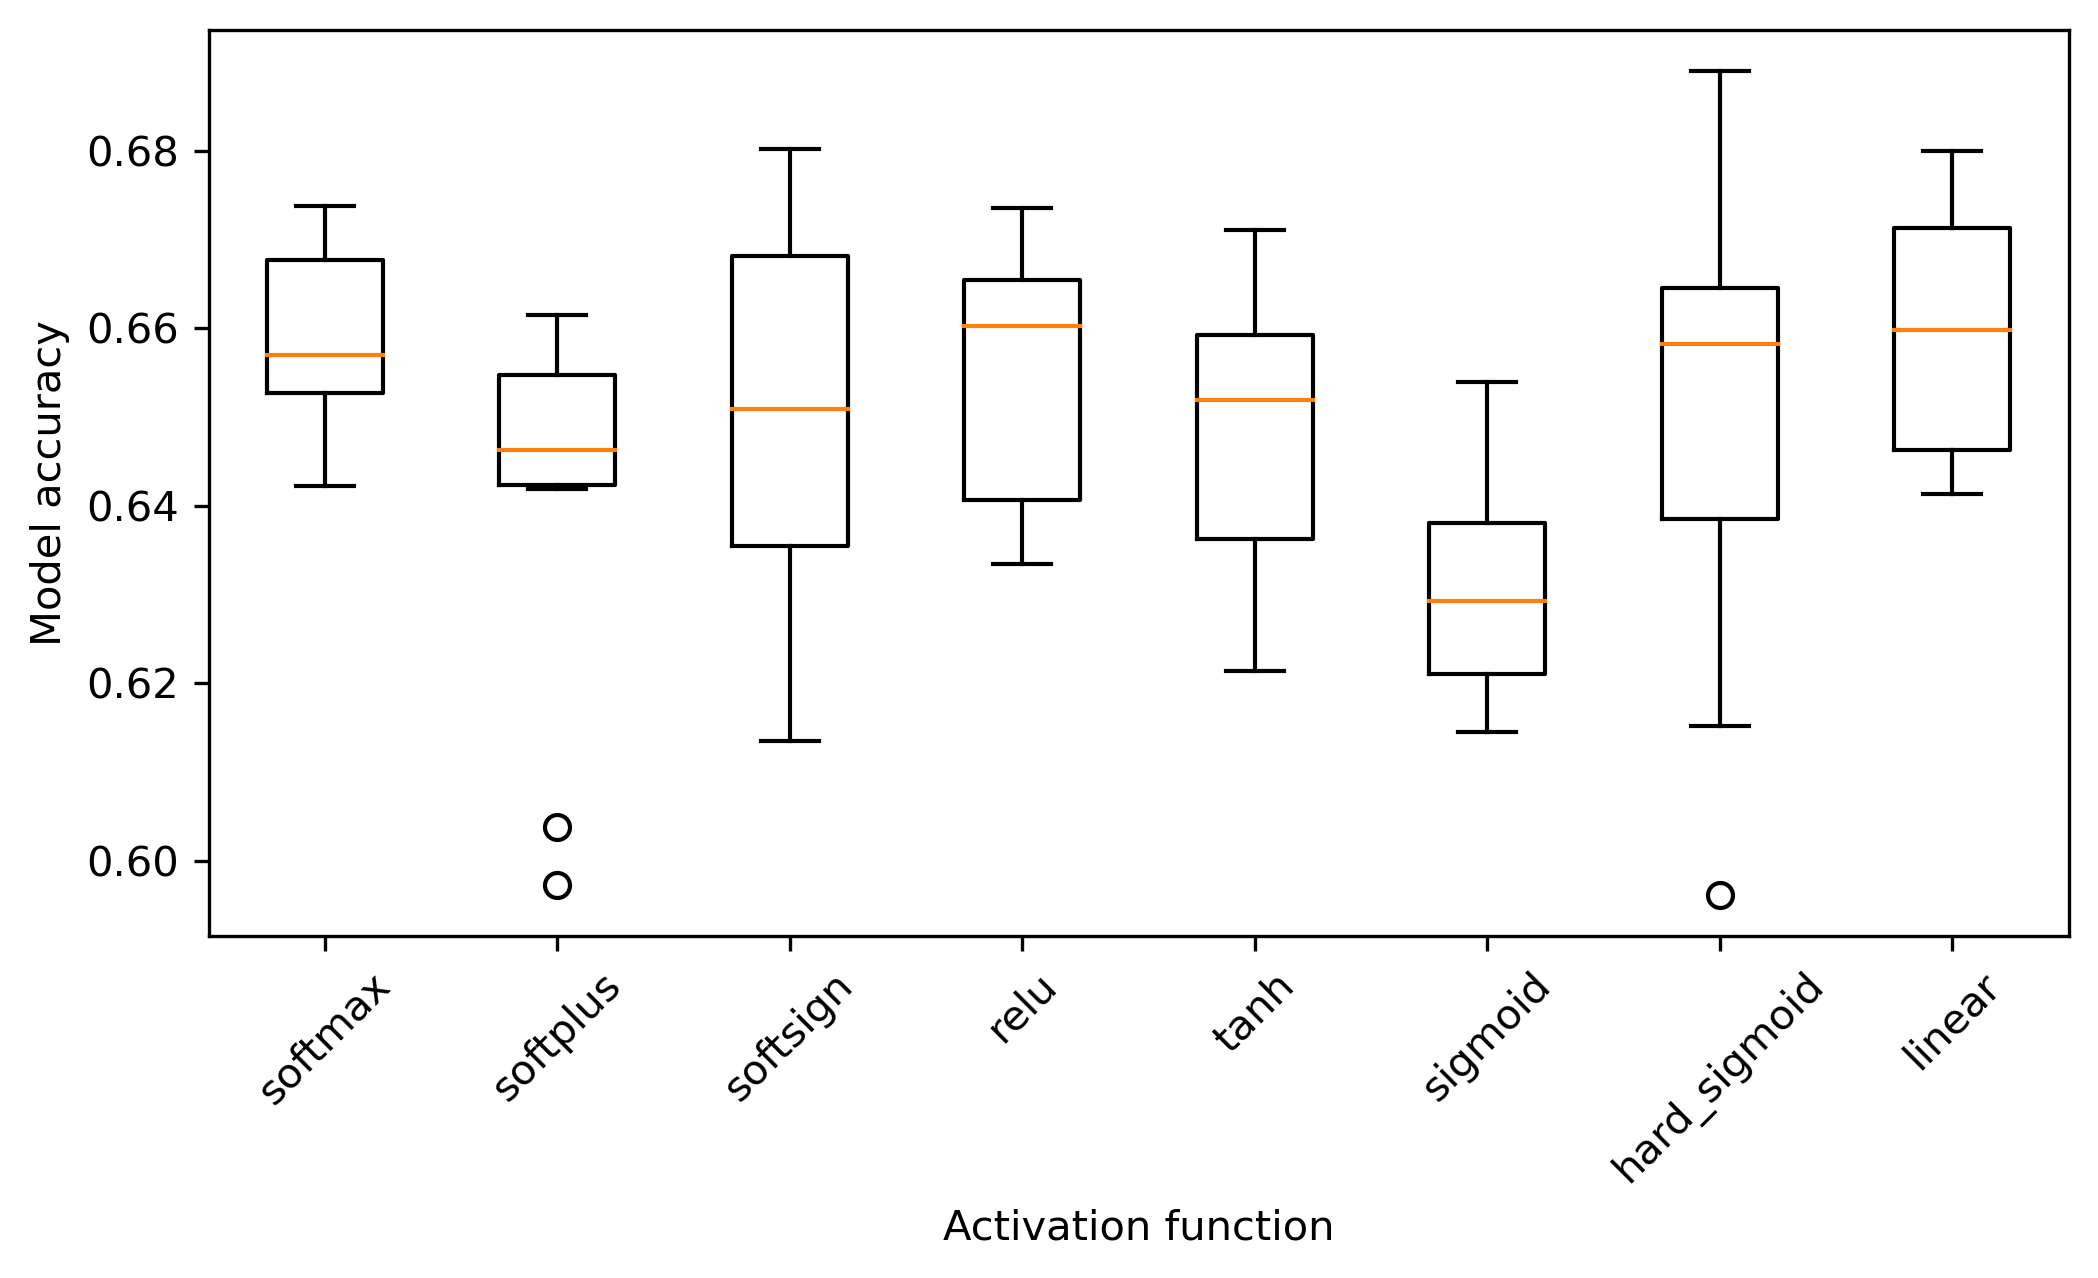

In [107]:
# Make results plot
data_to_plot = make_data_to_plot(grid_result, 10)
title = 'Box plot comparing activation functions'
x_label = 'Activation function'
fig = boxplot_parameters(data_to_plot, activation, title, x_label)